In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
p_values = pd.read_csv("IV_test_results/p_values_true_signals_LDAG_conf3.csv", index_col=0)

In [4]:
new_col_names = ["seed"]
new_col_names.append("confounder_source")
for x in range(2,p_values.shape[1]-2):
    new_col_names.append(f"control_source_{x-1}")
new_col_names.append("treatment_source")
new_col_names.append("outcome_source")

In [5]:
p_values.columns = new_col_names

In [6]:
p_values.columns

Index(['seed', 'confounder_source', 'control_source_1', 'control_source_2',
       'control_source_3', 'control_source_4', 'control_source_5',
       'control_source_6', 'treatment_source', 'outcome_source'],
      dtype='object')

In [7]:
long_df = p_values.melt(id_vars="seed")

In [8]:
long_df_subset = long_df.loc[long_df["variable"].isin(["confounder_source","control_source_1", "treatment_source"])]

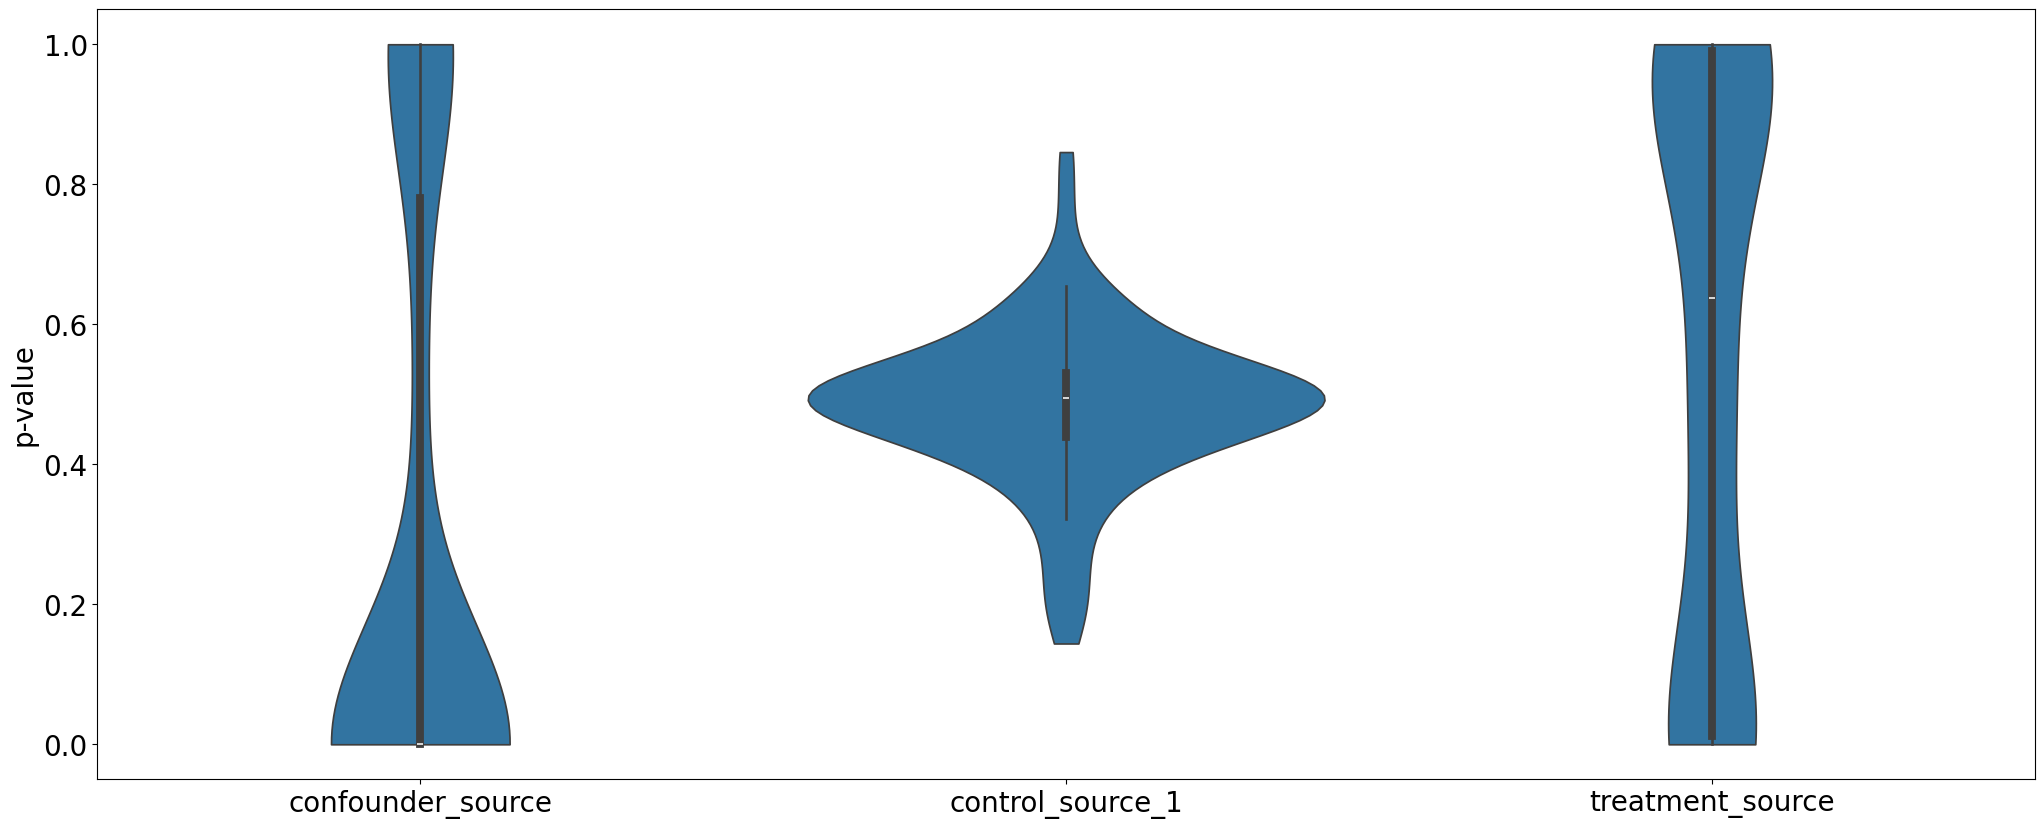

In [9]:
plt.figure(figsize= (25,10))
#plt.title("Distribution of the p-values for different TRUE sources, H0: source is a valid instrument for the treatment effect")
sns.violinplot(long_df_subset, x = "variable", y = "value", inner = "box", cut = 0)
plt.xlabel("")
plt.ylabel("p-value", fontsize = 20)
plt.xticks(fontsize=20)  
plt.yticks(fontsize =20)

plt.show()

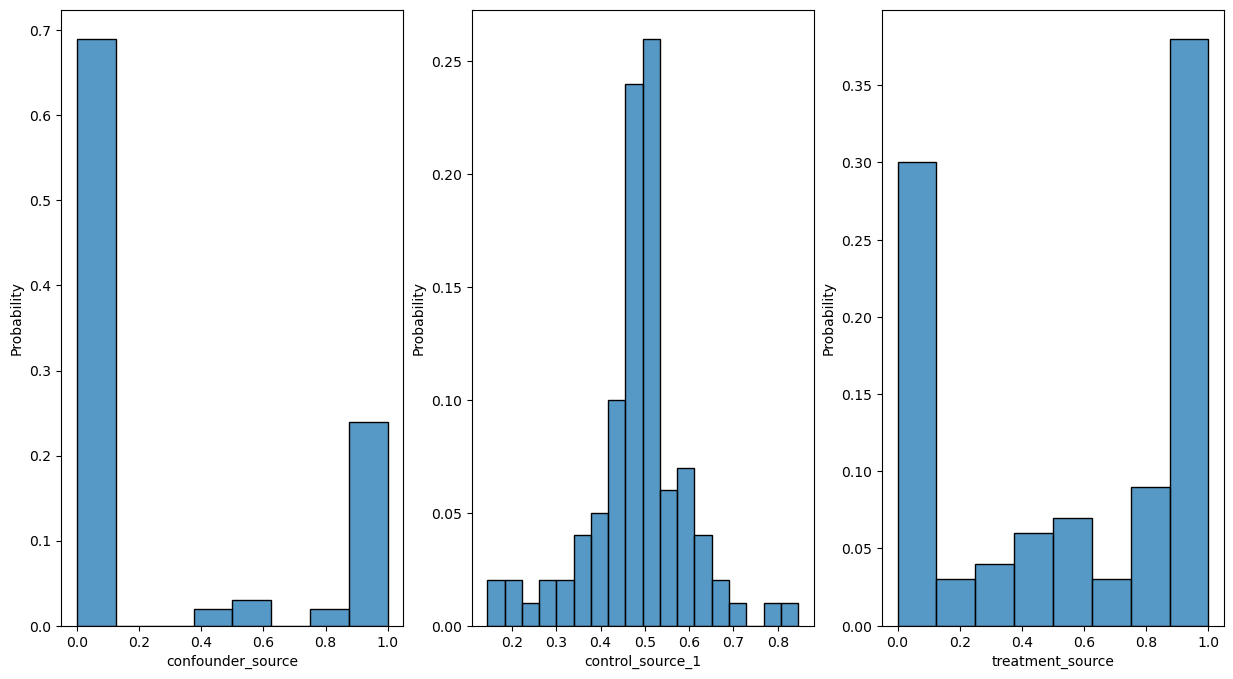

In [10]:
fg, ax = plt.subplots(1,3, figsize = (15,8))
cols = ["confounder_source","control_source_1", "treatment_source"]
for i in range(3):
    sns.histplot(p_values, x = cols[i], ax = ax[i], stat ="probability" )

plt.show()